## In this Assignment We are going to perfrom time series forcasting on temperature using the Deep Neural Network on jena_climate_2009_2016 dataset

#### Importing the required module for our Assignment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from math import ceil,floor

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import load_model

#### Loading the Data Set from tf-keras-dataset which is hosted on google cloud storage on which we will perform our timeseries forcasting using DNN

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

In [5]:
zip_path

'C:\\Users\\zidan\\.keras\\datasets\\jena_climate_2009_2016.csv.zip'

In [6]:
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
len(df)

420551

In [9]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


##### Our timeseries dataset is of 10 min interval but we want to do our analysis on hourly interval. So we will fetch hourly interval values from our dataframe 

In [11]:
# making the data hourly
df = df[5::6] # 5th index has 1st hour reading so starting from there then every 6th index will be the next hour reading therefore setting step_size=6

In [12]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [13]:
len(df) # size of our dataset decreased from 420551 to 70091

70091

##### setting Date Time column as index and Dropping it as a column

In [14]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.drop('Date Time',axis=1,inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


##### We will only do our time series forcating on Temperature column

<Axes: xlabel='Date Time'>

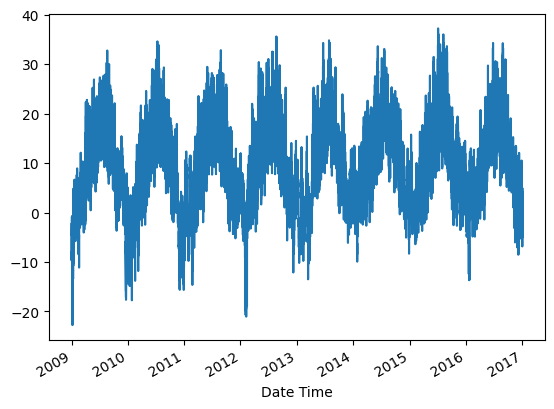

In [15]:
temp = df['T (degC)']
temp.plot()

In [16]:
temp_arr = temp.to_numpy()

##### Lets create Features and Label. We will use previous a window of size 'n' Which basically say how much values we need to look back to predict next value

In [17]:
from typing import Tuple 

In [18]:
def df_to_X_y(arr: [np.ndarray,pd.core.series.Series], window_size: int=5) -> Tuple[np.ndarray,np.ndarray]: 
    """Gets and transform the data into features and label based on window_size
    
    Args:
        arr (np.ndarray,pd.core.series.Series): data to be transformed into features and labels
        window_size (int): window_size say how much previous value to be dependent on for target 
            (default is 5)
    
    Returns:
        tupe: a tuple of features and label
    """
    if isinstance(arr,pd.core.series.Series):
        arr = arr.to_numpy()
    if not isinstance(arr,np.ndarray):
        raise TypeError(f'The input data need to be of Type {np.ndarray} or {pd.core.series.Series}')
    X = []
    y = []
    for i in range(len(arr)-window_size):
        #row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(arr[i:i+window_size])
        label = arr[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

### WINDOW SIZE = 5

In [50]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp_arr, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5), (70086,))

##### Splitting our dataset into Train,Test and Validation split

In [20]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5), (60000,), (5000, 5), (5000,), (5086, 5), (5086,))

In [21]:
X_train1

array([[-8.05, -8.88, -8.81, -9.05, -9.63],
       [-8.88, -8.81, -9.05, -9.63, -9.67],
       [-8.81, -9.05, -9.63, -9.67, -9.17],
       ...,
       [ 2.02,  2.27,  4.71,  6.07,  9.88],
       [ 2.27,  4.71,  6.07,  9.88, 13.53],
       [ 4.71,  6.07,  9.88, 13.53, 15.43]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [23]:
model1 = Sequential() # we will be using tenserflow sequential API for modelling

In [24]:
model1.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [25]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model1.add(Dropout(0.2))

In [26]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model1.add(Dropout(0.2))

In [27]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model1.add(Dropout(0.05))

In [28]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE,activation='relu'))
# model1.add(Dropout(0.2))

In [29]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model1.add(Dense(1,activation='linear'))

In [30]:
model1.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 50)                   300       
                                                                 
 dense_1 (Dense)             (1, 30)                   1530      
                                                                 
 dense_2 (Dense)             (1, 15)                   465       
                                                                 
 dense_3 (Dense)             (1, 5)                    80        
                                                                 
 dense_4 (Dense)             (1, 1)                    6         
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [33]:
cp1 = ModelCheckpoint('models/model1', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [34]:
logdir = 'logs/model2'

In [35]:
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [36]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [37]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist1 = model1.fit(~X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,tensorboard_callback1,patience])

Epoch 1/100
1873/1875 [============================>.] - ETA: 0s - loss: 1.4270 - root_mean_squared_error: 1.1946INFO:tensorflow:Assets written to: models\model1\assets


INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.4264 - root_mean_squared_error: 1.1943 - val_loss: 0.5847 - val_root_mean_squared_error: 0.7647
Epoch 2/100
1844/1875 [============================>.] - ETA: 0s - loss: 0.7160 - root_mean_squared_error: 0.8461INFO:tensorflow:Assets written to: models\model1\assets


INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.7142 - root_mean_squared_error: 0.8451 - val_loss: 0.4953 - val_root_mean_squared_error: 0.7038
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6978 - root_mean_squared_error: 0.8354 - val_loss: 0.5339 - val_root_mean_squared_error: 0.7307
Epoch 4/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6971 - root_mean_squared_error: 0.8349 - val_loss: 0.5270 - val_root_mean_squared_error: 0.7260
Epoch 5/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6835 - root_mean_squared_error: 0.8267 - val_loss: 0.5317 - val_root_mean_squared_error: 0.7292
Epoch 6/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6828 - root_mean_squared_error: 0.8263 - val_loss: 0.5002 - val_root_mean_squared_error: 0.7072
Epoch 7/100
1845/1875 [============================>.] - ETA: 0s - loss: 0.6711 - root_mean_squared_error: 0.8192INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6708 - root_mean_squared_error: 0.8190 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 8/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6797 - root_mean_squared_error: 0.8245 - val_loss: 0.5229 - val_root_mean_squared_error: 0.7231
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6675 - root_mean_squared_error: 0.8170 - val_loss: 0.5390 - val_root_mean_squared_error: 0.7342
Epoch 10/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6713 - root_mean_squared_error: 0.8194 - val_loss: 0.5222 - val_root_mean_squared_error: 0.7227
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6676 - root_mean_squared_error: 0.8170 - val_loss: 0.5897 - val_root_mean_squared_error: 0.7679
Epoch 12/100
1833/1875 [============================>.] - ETA: 0s - loss: 0.6658 - root_mean_squared_error: 0.8160INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6647 - root_mean_squared_error: 0.8153 - val_loss: 0.4785 - val_root_mean_squared_error: 0.6918
Epoch 13/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6624 - root_mean_squared_error: 0.8139 - val_loss: 0.4910 - val_root_mean_squared_error: 0.7007
Epoch 14/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6550 - root_mean_squared_error: 0.8093 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7085
Epoch 15/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6551 - root_mean_squared_error: 0.8094 - val_loss: 0.4940 - val_root_mean_squared_error: 0.7028
Epoch 16/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6609 - root_mean_squared_error: 0.8130 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 17/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6525 - root_mean_squared_error: 0.8078 - val_loss: 0.

In [52]:
hist1.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

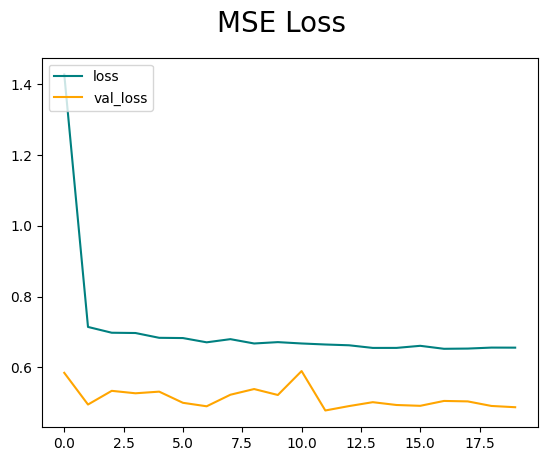

In [40]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['loss'], color='teal', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

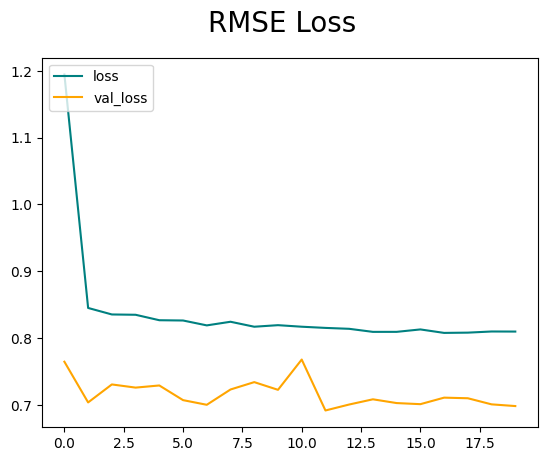

In [41]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist1.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
# loading the model
model1 = load_model('models/model1/')

In [93]:
# predicting train dataset on loaded model
train_predictions1 = model1.predict(X_train1).flatten()
# storing predicted and actual in a dataframe
train_results1 = pd.DataFrame(data={'Train Predictions':train_predictions1, 'Actuals':y_train1})
train_results1.head()

1875/1875 [==============================] - 1s 794us/step


,Train Predictions,Actuals
0,-9.680407,-9.67
1,-9.615618,-9.17
2,-8.705441,-8.10
3,-6.955798,-7.66
4,-6.634170,-7.04


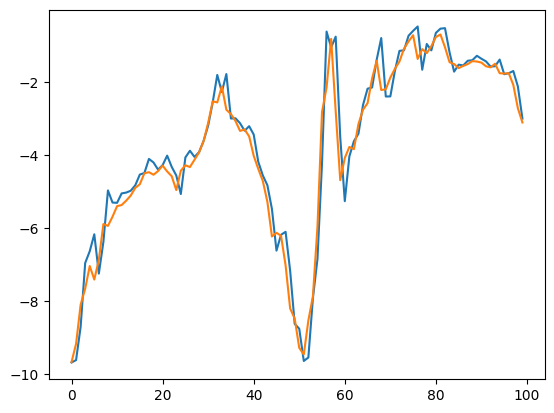

In [94]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results1['Train Predictions'][:100])
plt.plot(train_results1['Actuals'][:100])

In [95]:
# predicting validation dataset on loaded model
val_predictions1 = model1.predict(X_val1).flatten()
# storing predicted and actual in a dataframe
val_results1 = pd.DataFrame(data={'Val Predictions':val_predictions1, 'Actuals':y_val1})
val_results1.head()

157/157 [==============================] - 0s 798us/step


,Val Predictions,Actuals
0,15.646160,14.02
1,13.390832,13.67
2,13.129172,12.27
3,11.542672,11.19
4,10.469726,10.85


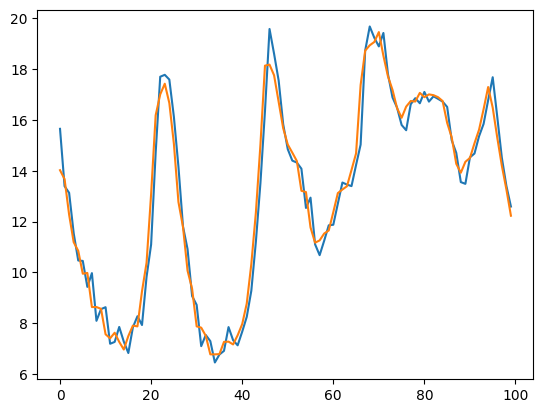

In [96]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results1['Val Predictions'][:100])
plt.plot(val_results1['Actuals'][:100])

In [97]:
# predicting validation dataset on loaded model
test_predictions1 = model1.predict(X_test1).flatten()
# storing predicted and actual in a dataframe
test_results1 = pd.DataFrame(data={'Test Predictions':test_predictions1, 'Actuals':y_test1})
test_results1.head()

159/159 [==============================] - 0s 866us/step


,Test Predictions,Actuals
0,14.433522,13.99
1,13.294379,13.46
2,12.948710,12.93
3,12.492018,12.43
4,12.055753,12.17


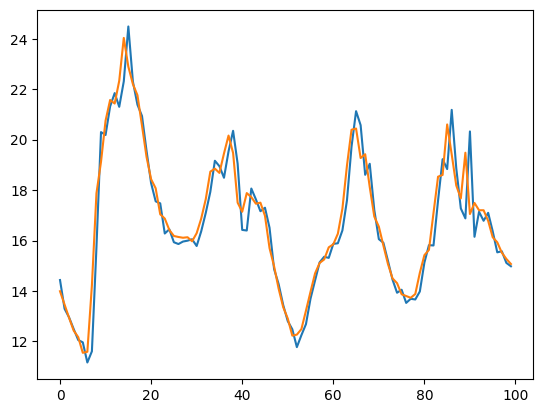

In [98]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results1['Test Predictions'][:100])
plt.plot(test_results1['Actuals'][:100])

### WINDOW SIZE = 10

In [54]:
WINDOW_SIZE = 10
X2, y2 = df_to_X_y(temp_arr, WINDOW_SIZE)
X2.shape, y2.shape

((70081, 10), (70081,))

##### Splitting our dataset into Train,Test and Validation split

In [55]:
X_train2, y_train2 = X2[:60000], y2[:60000]
X_val2, y_val2 = X2[60000:65000], y2[60000:65000]
X_test2, y_test2 = X2[65000:], y2[65000:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((60000, 10), (60000,), (5000, 10), (5000,), (5081, 10), (5081,))

In [56]:
X_train2

array([[-8.05, -8.88, -8.81, ..., -8.1 , -7.66, -7.04],
       [-8.88, -8.81, -9.05, ..., -7.66, -7.04, -7.41],
       [-8.81, -9.05, -9.63, ..., -7.04, -7.41, -6.87],
       ...,
       [ 2.02,  2.27,  4.71, ..., 15.54, 14.02, 13.67],
       [ 2.27,  4.71,  6.07, ..., 14.02, 13.67, 12.27],
       [ 4.71,  6.07,  9.88, ..., 13.67, 12.27, 11.19]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [57]:
model2 = Sequential() # we will be using tenserflow sequential API for modelling

In [58]:
model2.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [61]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model2.add(Dropout(0.2))

In [62]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model2.add(Dropout(0.2))

In [63]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model2.add(Dropout(0.05))

In [64]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE,activation='relu'))
# model2.add(Dropout(0.2))

In [65]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model2.add(Dense(1,activation='linear'))

In [66]:
model2.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (1, 100)                  1100      
                                                                 
 dense_6 (Dense)             (1, 60)                   6060      
                                                                 
 dense_7 (Dense)             (1, 100)                  6100      
                                                                 
 dense_8 (Dense)             (1, 60)                   6060      
                                                                 
 dense_9 (Dense)             (1, 30)                   1830      
                                                                 
 dense_10 (Dense)            (1, 10)                   310       
                                                                 
 dense_11 (Dense)            (1, 1)                   

In [67]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [74]:
cp2 = ModelCheckpoint('models/model2', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [75]:
logdir = 'logs/model2'

In [76]:
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [77]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [79]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2,tensorboard_callback2,patience])

Epoch 1/100
1856/1875 [============================>.] - ETA: 0s - loss: 1.4561 - root_mean_squared_error: 1.2067INFO:tensorflow:Assets written to: models\model2\assets


INFO:tensorflow:Assets written to: models\model2\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.4490 - root_mean_squared_error: 1.2037 - val_loss: 0.4997 - val_root_mean_squared_error: 0.7069
Epoch 2/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7404 - root_mean_squared_error: 0.8604 - val_loss: 0.5930 - val_root_mean_squared_error: 0.7701
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7091 - root_mean_squared_error: 0.8421 - val_loss: 0.5163 - val_root_mean_squared_error: 0.7185
Epoch 4/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7104 - root_mean_squared_error: 0.8429 - val_loss: 0.6738 - val_root_mean_squared_error: 0.8209
Epoch 5/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.6988 - root_mean_squared_error: 0.8359INFO:tensorflow:Assets written to: models\model2\assets


INFO:tensorflow:Assets written to: models\model2\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.6987 - root_mean_squared_error: 0.8359 - val_loss: 0.4979 - val_root_mean_squared_error: 0.7056
Epoch 6/100
1870/1875 [============================>.] - ETA: 0s - loss: 0.6854 - root_mean_squared_error: 0.8279INFO:tensorflow:Assets written to: models\model2\assets


INFO:tensorflow:Assets written to: models\model2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6851 - root_mean_squared_error: 0.8277 - val_loss: 0.4761 - val_root_mean_squared_error: 0.6900
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6912 - root_mean_squared_error: 0.8314 - val_loss: 0.5009 - val_root_mean_squared_error: 0.7078
Epoch 8/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6609 - root_mean_squared_error: 0.8129 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7084
Epoch 9/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6673 - root_mean_squared_error: 0.8169 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957
Epoch 10/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6590 - root_mean_squared_error: 0.8118 - val_loss: 0.6043 - val_root_mean_squared_error: 0.7774
Epoch 11/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6731 - root_mean_squared_error: 0.8204 - val_loss: 0.486

INFO:tensorflow:Assets written to: models\model2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6571 - root_mean_squared_error: 0.8106 - val_loss: 0.4602 - val_root_mean_squared_error: 0.6784
Epoch 14/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6442 - root_mean_squared_error: 0.8026 - val_loss: 0.4689 - val_root_mean_squared_error: 0.6847
Epoch 15/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6510 - root_mean_squared_error: 0.8068 - val_loss: 0.4843 - val_root_mean_squared_error: 0.6959
Epoch 16/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6470 - root_mean_squared_error: 0.8043 - val_loss: 0.4747 - val_root_mean_squared_error: 0.6890
Epoch 17/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6453 - root_mean_squared_error: 0.8033 - val_loss: 0.4637 - val_root_mean_squared_error: 0.6810


In [80]:
hist2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

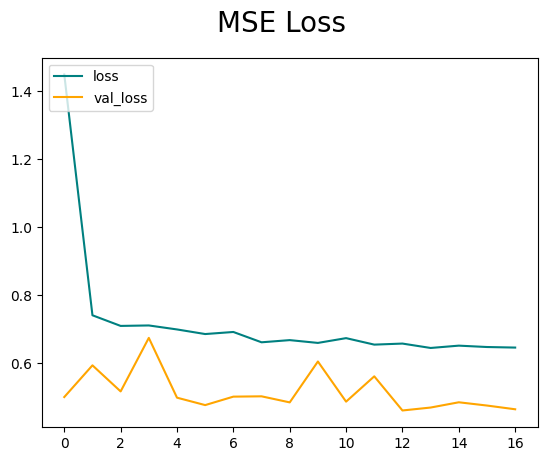

In [81]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

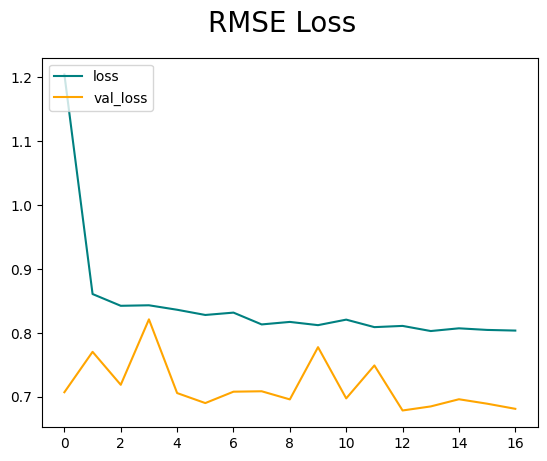

In [82]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist2.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [83]:
# loading the model
model2 = load_model('models/model2/')

In [86]:
# predicting train dataset on loaded model
train_predictions2 = model2.predict(X_train2).flatten()
# storing predicted and actual in a dataframe
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train2})
train_results2.head()

1875/1875 [==============================] - 2s 819us/step


,Train Predictions,Actuals
0,-6.451700,-7.41
1,-7.325345,-6.87
2,-6.619764,-5.89
3,-5.342227,-5.94
4,-5.585508,-5.69


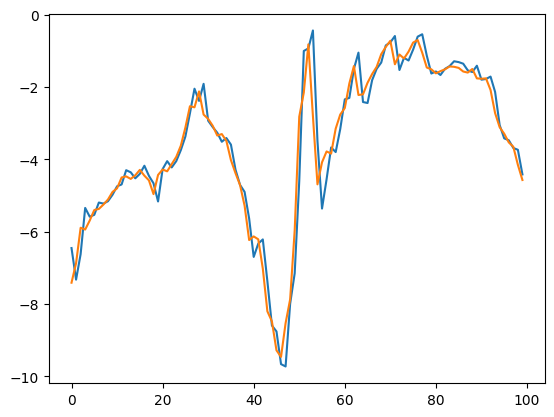

In [87]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])

In [88]:
# predicting validation dataset on loaded model
val_predictions2 = model2.predict(X_val2).flatten()
# storing predicted and actual in a dataframe
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val2})
val_results2.head()

157/157 [==============================] - 0s 756us/step


,Val Predictions,Actuals
0,10.062751,9.95
1,9.083187,9.98
2,9.566764,8.64
3,8.083587,8.64
4,8.550651,8.57


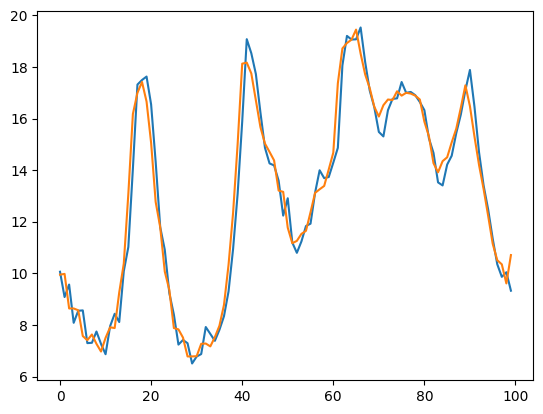

In [89]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])

In [91]:
# predicting validation dataset on loaded model
test_predictions2 = model2.predict(X_test2).flatten()
# storing predicted and actual in a dataframe
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test2})
test_results2.head()

159/159 [==============================] - 0s 766us/step


,Test Predictions,Actuals
0,11.998292,11.55
1,11.325411,11.59
2,11.632228,14.22
3,15.853775,17.87
4,20.034418,19.12


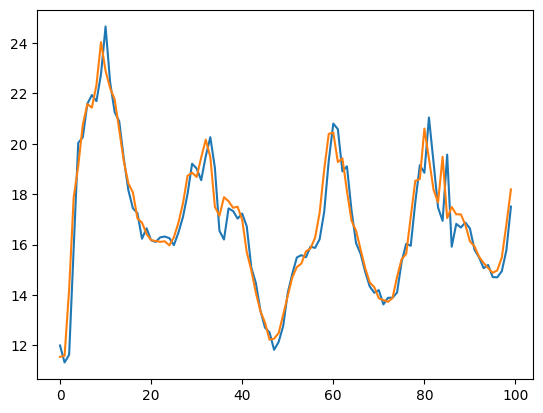

In [92]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])

### WINDOW SIZE = 15

In [99]:
WINDOW_SIZE = 15
X3, y3 = df_to_X_y(temp_arr, WINDOW_SIZE)
X3.shape, y3.shape

((70076, 15), (70076,))

##### Splitting our dataset into Train,Test and Validation split

In [100]:
X_train3, y_train3 = X3[:60000], y3[:60000]
X_val3, y_val3 = X3[60000:65000], y3[60000:65000]
X_test3, y_test3 = X3[65000:], y3[65000:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((60000, 15), (60000,), (5000, 15), (5000,), (5076, 15), (5076,))

In [101]:
X_train3

array([[-8.05, -8.88, -8.81, ..., -5.89, -5.94, -5.69],
       [-8.88, -8.81, -9.05, ..., -5.94, -5.69, -5.4 ],
       [-8.81, -9.05, -9.63, ..., -5.69, -5.4 , -5.37],
       ...,
       [ 2.02,  2.27,  4.71, ..., 10.85,  9.95,  9.98],
       [ 2.27,  4.71,  6.07, ...,  9.95,  9.98,  8.64],
       [ 4.71,  6.07,  9.88, ...,  9.98,  8.64,  8.64]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [102]:
model3 = Sequential() # we will be using tenserflow sequential API for modelling

In [103]:
model3.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [104]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model3.add(Dropout(0.2))

In [105]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model3.add(Dropout(0.2))

In [106]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model3.add(Dropout(0.05))

In [107]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE,activation='relu'))
# model3.add(Dropout(0.2))

In [108]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model3.add(Dense(1,activation='linear'))

In [109]:
model3.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (1, 150)                  2400      
                                                                 
 dense_13 (Dense)            (1, 90)                   13590     
                                                                 
 dense_14 (Dense)            (1, 45)                   4095      
                                                                 
 dense_15 (Dense)            (1, 15)                   690       
                                                                 
 dense_16 (Dense)            (1, 1)                    16        
                                                                 
Total params: 20791 (81.21 KB)
Trainable params: 20791 (81.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [111]:
cp3 = ModelCheckpoint('models/model3', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [112]:
logdir = 'logs/model3'

In [113]:
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [114]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [115]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3,tensorboard_callback3,patience])

Epoch 1/100
1867/1875 [============================>.] - ETA: 0s - loss: 1.1392 - root_mean_squared_error: 1.0673INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.1376 - root_mean_squared_error: 1.0666 - val_loss: 0.5093 - val_root_mean_squared_error: 0.7137
Epoch 2/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.6979 - root_mean_squared_error: 0.8354INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6981 - root_mean_squared_error: 0.8355 - val_loss: 0.5066 - val_root_mean_squared_error: 0.7118
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6778 - root_mean_squared_error: 0.8233 - val_loss: 0.5160 - val_root_mean_squared_error: 0.7183
Epoch 4/100
1871/1875 [============================>.] - ETA: 0s - loss: 0.6608 - root_mean_squared_error: 0.8129INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6605 - root_mean_squared_error: 0.8127 - val_loss: 0.4724 - val_root_mean_squared_error: 0.6873
Epoch 5/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6419 - root_mean_squared_error: 0.8012 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6982
Epoch 6/100
1842/1875 [============================>.] - ETA: 0s - loss: 0.6344 - root_mean_squared_error: 0.7965INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6358 - root_mean_squared_error: 0.7973 - val_loss: 0.4697 - val_root_mean_squared_error: 0.6853
Epoch 7/100
1863/1875 [============================>.] - ETA: 0s - loss: 0.6360 - root_mean_squared_error: 0.7975INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6350 - root_mean_squared_error: 0.7968 - val_loss: 0.4679 - val_root_mean_squared_error: 0.6840
Epoch 8/100
1869/1875 [============================>.] - ETA: 0s - loss: 0.6312 - root_mean_squared_error: 0.7945INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6304 - root_mean_squared_error: 0.7940 - val_loss: 0.4561 - val_root_mean_squared_error: 0.6753
Epoch 9/100
1857/1875 [============================>.] - ETA: 0s - loss: 0.6274 - root_mean_squared_error: 0.7921INFO:tensorflow:Assets written to: models\model3\assets


INFO:tensorflow:Assets written to: models\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6266 - root_mean_squared_error: 0.7916 - val_loss: 0.4548 - val_root_mean_squared_error: 0.6744
Epoch 10/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6233 - root_mean_squared_error: 0.7895 - val_loss: 0.4627 - val_root_mean_squared_error: 0.6802
Epoch 11/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6093 - root_mean_squared_error: 0.7806 - val_loss: 0.4696 - val_root_mean_squared_error: 0.6853
Epoch 12/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6119 - root_mean_squared_error: 0.7822 - val_loss: 0.5354 - val_root_mean_squared_error: 0.7317
Epoch 13/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6110 - root_mean_squared_error: 0.7817 - val_loss: 0.4646 - val_root_mean_squared_error: 0.6816
Epoch 14/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6102 - root_mean_squared_error: 0.7811 - val_loss: 0.

In [116]:
hist3.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

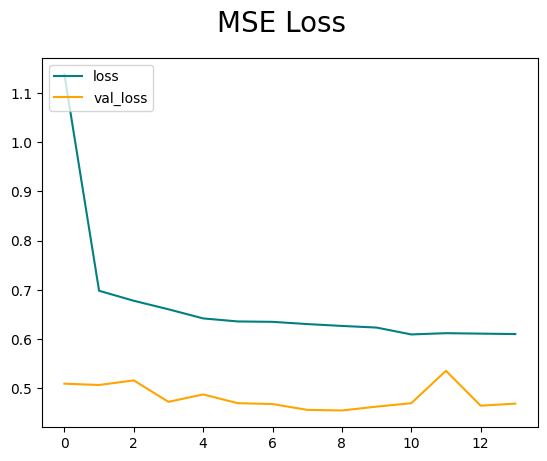

In [117]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

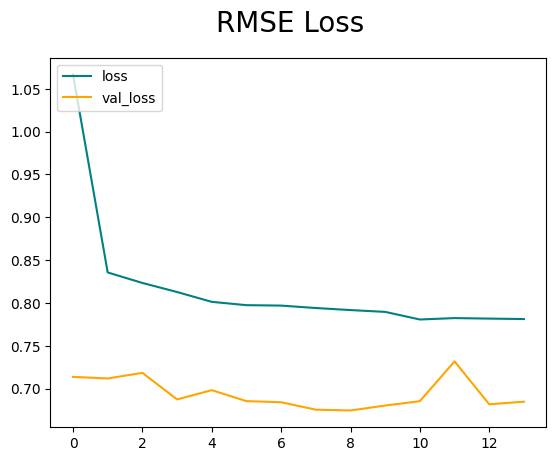

In [118]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist3.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [119]:
# loading the model
model3 = load_model('models/model3/')

In [120]:
# predicting train dataset on loaded model
train_predictions3 = model3.predict(X_train3).flatten()
# storing predicted and actual in a dataframe
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train3})
train_results3.head()

1875/1875 [==============================] - 2s 788us/step


,Train Predictions,Actuals
0,-5.312512,-5.40
1,-5.009355,-5.37
2,-5.035666,-5.25
3,-4.952360,-5.11
4,-4.868197,-4.90


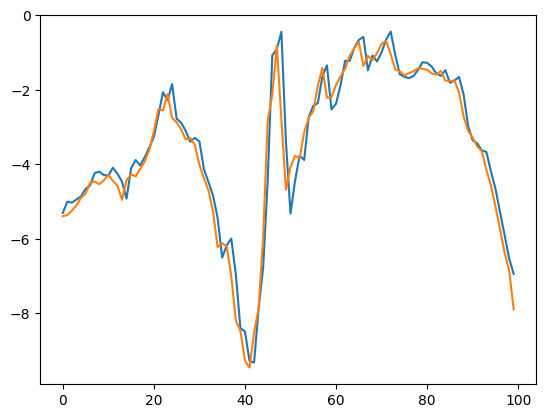

In [121]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results3['Train Predictions'][:100])
plt.plot(train_results3['Actuals'][:100])

In [122]:
# predicting validation dataset on loaded model
val_predictions3 = model3.predict(X_val3).flatten()
# storing predicted and actual in a dataframe
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val3})
val_results3.head()

157/157 [==============================] - 0s 842us/step


,Val Predictions,Actuals
0,7.932024,7.57
1,6.994466,7.41
2,7.276251,7.63
3,7.979993,7.27
4,7.685122,6.97


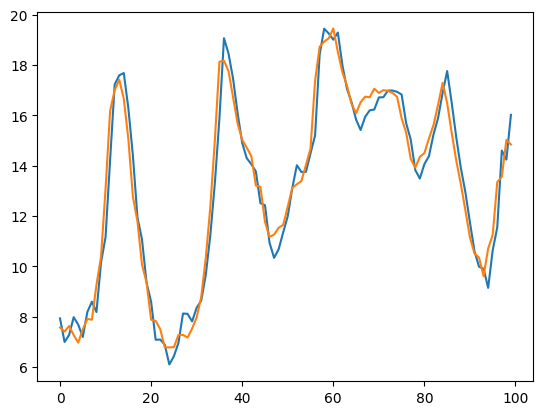

In [123]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results3['Val Predictions'][:100])
plt.plot(val_results3['Actuals'][:100])

In [124]:
# predicting validation dataset on loaded model
test_predictions3 = model3.predict(X_test3).flatten()
# storing predicted and actual in a dataframe
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test3})
test_results3.head()

159/159 [==============================] - 0s 928us/step


,Test Predictions,Actuals
0,20.436012,20.75
1,21.785686,21.57
2,22.244041,21.43
3,21.607763,22.33
4,22.561432,24.03


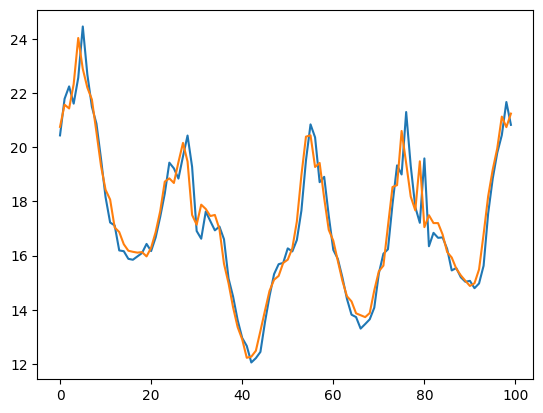

In [125]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results3['Test Predictions'][:100])
plt.plot(test_results3['Actuals'][:100])

### WINDOW SIZE = 20

In [126]:
WINDOW_SIZE = 20
X4, y4 = df_to_X_y(temp_arr, WINDOW_SIZE)
X4.shape, y4.shape

((70071, 20), (70071,))

##### Splitting our dataset into Train,Test and Validation split

In [127]:
X_train4, y_train4 = X4[:60000], y4[:60000]
X_val4, y_val4 = X4[60000:65000], y4[60000:65000]
X_test4, y_test4 = X4[65000:], y4[65000:]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((60000, 20), (60000,), (5000, 20), (5000,), (5071, 20), (5071,))

In [128]:
X_train4

array([[-8.05, -8.88, -8.81, ..., -5.25, -5.11, -4.9 ],
       [-8.88, -8.81, -9.05, ..., -5.11, -4.9 , -4.8 ],
       [-8.81, -9.05, -9.63, ..., -4.9 , -4.8 , -4.5 ],
       ...,
       [ 2.02,  2.27,  4.71, ...,  8.57,  7.57,  7.41],
       [ 2.27,  4.71,  6.07, ...,  7.57,  7.41,  7.63],
       [ 4.71,  6.07,  9.88, ...,  7.41,  7.63,  7.27]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [129]:
model4 = Sequential() # we will be using tenserflow sequential API for modelling

In [130]:
model4.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [131]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model4.add(Dropout(0.2))

In [132]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model4.add(Dropout(0.2))

In [133]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model4.add(Dropout(0.05))

In [134]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE,activation='relu'))
# model4.add(Dropout(0.2))

In [135]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model4.add(Dense(1,activation='linear'))

In [136]:
model4.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (1, 200)                  4200      
                                                                 
 dense_18 (Dense)            (1, 120)                  24120     
                                                                 
 dense_19 (Dense)            (1, 60)                   7260      
                                                                 
 dense_20 (Dense)            (1, 20)                   1220      
                                                                 
 dense_21 (Dense)            (1, 1)                    21        
                                                                 
Total params: 36821 (143.83 KB)
Trainable params: 36821 (143.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [138]:
cp4 = ModelCheckpoint('models/model4', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [139]:
logdir = 'logs/model4'

In [140]:
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [141]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [142]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4,tensorboard_callback4,patience])

Epoch 1/100
1839/1875 [============================>.] - ETA: 0s - loss: 1.0687 - root_mean_squared_error: 1.0338INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.0622 - root_mean_squared_error: 1.0306 - val_loss: 0.5155 - val_root_mean_squared_error: 0.7180
Epoch 2/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7117 - root_mean_squared_error: 0.8436 - val_loss: 0.6169 - val_root_mean_squared_error: 0.7854
Epoch 3/100
1850/1875 [============================>.] - ETA: 0s - loss: 0.6724 - root_mean_squared_error: 0.8200INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6722 - root_mean_squared_error: 0.8199 - val_loss: 0.4936 - val_root_mean_squared_error: 0.7025
Epoch 4/100
1854/1875 [============================>.] - ETA: 0s - loss: 0.6713 - root_mean_squared_error: 0.8194INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.6701 - root_mean_squared_error: 0.8186 - val_loss: 0.4879 - val_root_mean_squared_error: 0.6985
Epoch 5/100
1862/1875 [============================>.] - ETA: 0s - loss: 0.6440 - root_mean_squared_error: 0.8025INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6431 - root_mean_squared_error: 0.8020 - val_loss: 0.4705 - val_root_mean_squared_error: 0.6860
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6337 - root_mean_squared_error: 0.7960 - val_loss: 0.4721 - val_root_mean_squared_error: 0.6871
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6292 - root_mean_squared_error: 0.7932 - val_loss: 0.4806 - val_root_mean_squared_error: 0.6933
Epoch 8/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.6154 - root_mean_squared_error: 0.7845INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6153 - root_mean_squared_error: 0.7844 - val_loss: 0.4627 - val_root_mean_squared_error: 0.6803
Epoch 9/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6197 - root_mean_squared_error: 0.7872 - val_loss: 0.5191 - val_root_mean_squared_error: 0.7205
Epoch 10/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6081 - root_mean_squared_error: 0.7798 - val_loss: 0.5317 - val_root_mean_squared_error: 0.7292
Epoch 11/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6097 - root_mean_squared_error: 0.7808 - val_loss: 0.4679 - val_root_mean_squared_error: 0.6841
Epoch 12/100
1841/1875 [============================>.] - ETA: 0s - loss: 0.6028 - root_mean_squared_error: 0.7764INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6067 - root_mean_squared_error: 0.7789 - val_loss: 0.4505 - val_root_mean_squared_error: 0.6712
Epoch 13/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.5982 - root_mean_squared_error: 0.7734INFO:tensorflow:Assets written to: models\model4\assets


INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.5981 - root_mean_squared_error: 0.7733 - val_loss: 0.4438 - val_root_mean_squared_error: 0.6662
Epoch 14/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5970 - root_mean_squared_error: 0.7727 - val_loss: 0.4680 - val_root_mean_squared_error: 0.6841
Epoch 15/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700 - val_loss: 0.4541 - val_root_mean_squared_error: 0.6739
Epoch 16/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5951 - root_mean_squared_error: 0.7714 - val_loss: 0.5221 - val_root_mean_squared_error: 0.7226
Epoch 17/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5838 - root_mean_squared_error: 0.7640 - val_loss: 0.5014 - val_root_mean_squared_error: 0.7081
Epoch 18/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5854 - root_mean_squared_error: 0.7651 - val_loss: 0.

INFO:tensorflow:Assets written to: models\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.5790 - root_mean_squared_error: 0.7609 - val_loss: 0.4380 - val_root_mean_squared_error: 0.6618
Epoch 21/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5838 - root_mean_squared_error: 0.7641 - val_loss: 0.4598 - val_root_mean_squared_error: 0.6781
Epoch 22/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5818 - root_mean_squared_error: 0.7627 - val_loss: 0.4794 - val_root_mean_squared_error: 0.6924
Epoch 23/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5810 - root_mean_squared_error: 0.7622 - val_loss: 0.4414 - val_root_mean_squared_error: 0.6643


In [143]:
hist4.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

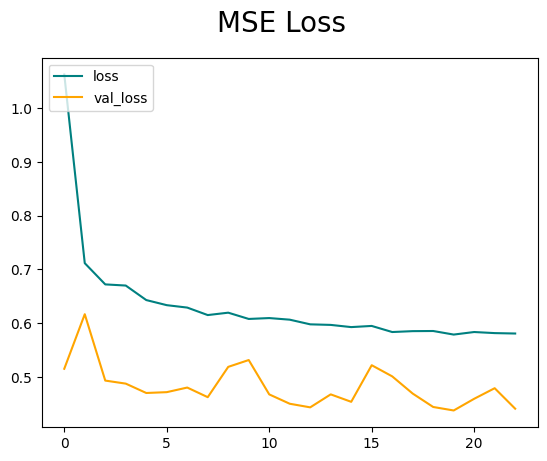

In [144]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

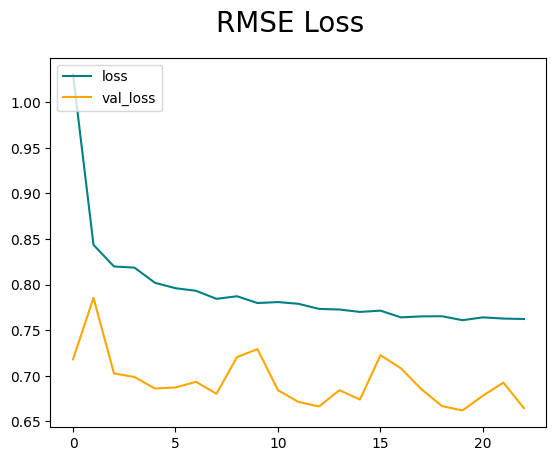

In [145]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist4.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [146]:
# loading the model
model4 = load_model('models/model4/')

In [147]:
# predicting train dataset on loaded model
train_predictions4 = model4.predict(X_train4).flatten()
# storing predicted and actual in a dataframe
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train4})
train_results4.head()

1875/1875 [==============================] - 2s 920us/step


,Train Predictions,Actuals
0,-5.216691,-4.80
1,-5.054827,-4.50
2,-4.756462,-4.47
3,-4.749175,-4.54
4,-4.887594,-4.44


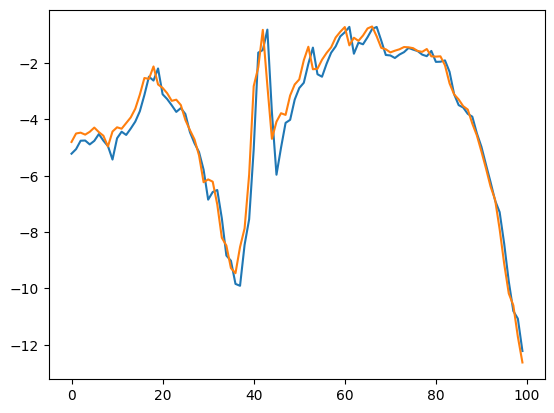

In [148]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results4['Train Predictions'][:100])
plt.plot(train_results4['Actuals'][:100])

In [149]:
# predicting validation dataset on loaded model
val_predictions4 = model4.predict(X_val4).flatten()
# storing predicted and actual in a dataframe
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val4})
val_results4.head()

157/157 [==============================] - 0s 1ms/step


,Val Predictions,Actuals
0,6.702616,7.50
1,7.855350,7.91
2,8.641546,7.88
3,8.435550,9.26
4,10.130505,10.38


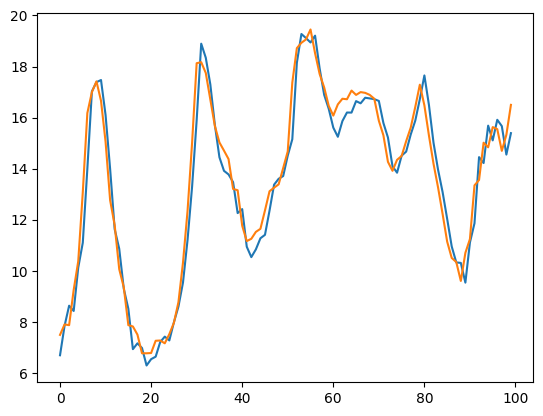

In [150]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results4['Val Predictions'][:100])
plt.plot(val_results4['Actuals'][:100])

In [151]:
# predicting validation dataset on loaded model
test_predictions4 = model4.predict(X_test4).flatten()
# storing predicted and actual in a dataframe
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test4})
test_results4.head()

159/159 [==============================] - 0s 1ms/step


,Test Predictions,Actuals
0,24.220442,22.89
1,22.582844,22.20
2,21.511429,21.76
3,20.805557,20.55
4,19.292419,19.31


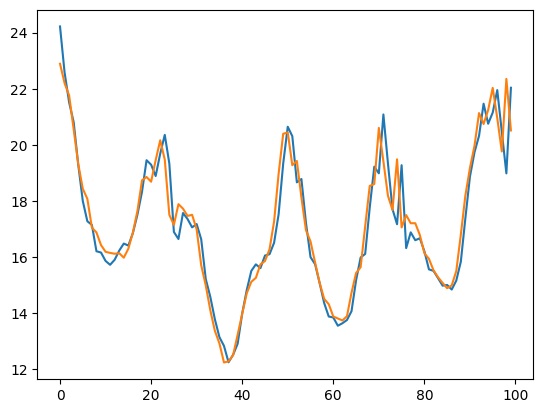

In [152]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results4['Test Predictions'][:100])
plt.plot(test_results4['Actuals'][:100])

In [19]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp_arr, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5), (70086,))

##### Splitting our dataset into Train,Test and Validation split

In [20]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5), (60000,), (5000, 5), (5000,), (5086, 5), (5086,))

In [21]:
X_train1

array([[-8.05, -8.88, -8.81, -9.05, -9.63],
       [-8.88, -8.81, -9.05, -9.63, -9.67],
       [-8.81, -9.05, -9.63, -9.67, -9.17],
       ...,
       [ 2.02,  2.27,  4.71,  6.07,  9.88],
       [ 2.27,  4.71,  6.07,  9.88, 13.53],
       [ 4.71,  6.07,  9.88, 13.53, 15.43]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [23]:
model1 = Sequential() # we will be using tenserflow sequential API for modelling

In [24]:
model1.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [25]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model1.add(Dropout(0.2))

In [26]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model1.add(Dropout(0.2))

In [27]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model1.add(Dropout(0.05))

In [28]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE,activation='relu'))
# model1.add(Dropout(0.2))

In [29]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model1.add(Dense(1,activation='linear'))

In [30]:
model1.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 50)                   300       
                                                                 
 dense_1 (Dense)             (1, 30)                   1530      
                                                                 
 dense_2 (Dense)             (1, 15)                   465       
                                                                 
 dense_3 (Dense)             (1, 5)                    80        
                                                                 
 dense_4 (Dense)             (1, 1)                    6         
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [33]:
cp1 = ModelCheckpoint('models/model1', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [34]:
logdir = 'logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [37]:
hist = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,tensorboard_callback,patience])

Epoch 1/100
1873/1875 [============================>.] - ETA: 0s - loss: 1.4270 - root_mean_squared_error: 1.1946INFO:tensorflow:Assets written to: models\model1\assets


INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.4264 - root_mean_squared_error: 1.1943 - val_loss: 0.5847 - val_root_mean_squared_error: 0.7647
Epoch 2/100
1844/1875 [============================>.] - ETA: 0s - loss: 0.7160 - root_mean_squared_error: 0.8461INFO:tensorflow:Assets written to: models\model1\assets


INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.7142 - root_mean_squared_error: 0.8451 - val_loss: 0.4953 - val_root_mean_squared_error: 0.7038
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6978 - root_mean_squared_error: 0.8354 - val_loss: 0.5339 - val_root_mean_squared_error: 0.7307
Epoch 4/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6971 - root_mean_squared_error: 0.8349 - val_loss: 0.5270 - val_root_mean_squared_error: 0.7260
Epoch 5/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6835 - root_mean_squared_error: 0.8267 - val_loss: 0.5317 - val_root_mean_squared_error: 0.7292
Epoch 6/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6828 - root_mean_squared_error: 0.8263 - val_loss: 0.5002 - val_root_mean_squared_error: 0.7072
Epoch 7/100
1845/1875 [============================>.] - ETA: 0s - loss: 0.6711 - root_mean_squared_error: 0.8192INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6708 - root_mean_squared_error: 0.8190 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 8/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6797 - root_mean_squared_error: 0.8245 - val_loss: 0.5229 - val_root_mean_squared_error: 0.7231
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6675 - root_mean_squared_error: 0.8170 - val_loss: 0.5390 - val_root_mean_squared_error: 0.7342
Epoch 10/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6713 - root_mean_squared_error: 0.8194 - val_loss: 0.5222 - val_root_mean_squared_error: 0.7227
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6676 - root_mean_squared_error: 0.8170 - val_loss: 0.5897 - val_root_mean_squared_error: 0.7679
Epoch 12/100
1833/1875 [============================>.] - ETA: 0s - loss: 0.6658 - root_mean_squared_error: 0.8160INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: models\model1\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6647 - root_mean_squared_error: 0.8153 - val_loss: 0.4785 - val_root_mean_squared_error: 0.6918
Epoch 13/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6624 - root_mean_squared_error: 0.8139 - val_loss: 0.4910 - val_root_mean_squared_error: 0.7007
Epoch 14/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6550 - root_mean_squared_error: 0.8093 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7085
Epoch 15/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6551 - root_mean_squared_error: 0.8094 - val_loss: 0.4940 - val_root_mean_squared_error: 0.7028
Epoch 16/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6609 - root_mean_squared_error: 0.8130 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 17/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6525 - root_mean_squared_error: 0.8078 - val_loss: 0.

#### Plot Performance

In [38]:
max_loss = ceil(max(max(hist.history['loss']),max(hist.history['val_loss'])))
min_loss = max(max(hist.history['loss']),max(hist.history['val_loss']))

In [39]:
hist.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

##### MSE LOSS PLOT

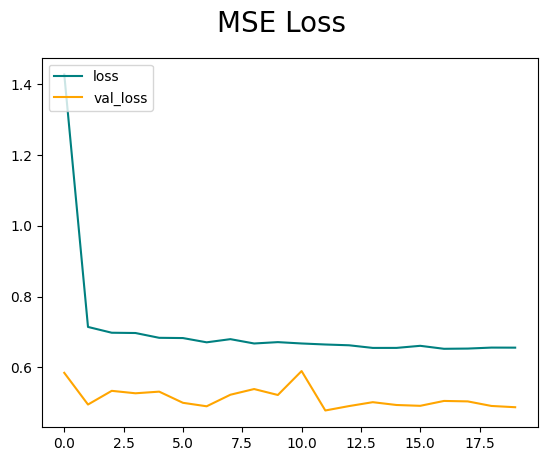

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
# plt.ylim(max_loss, min_loss)
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

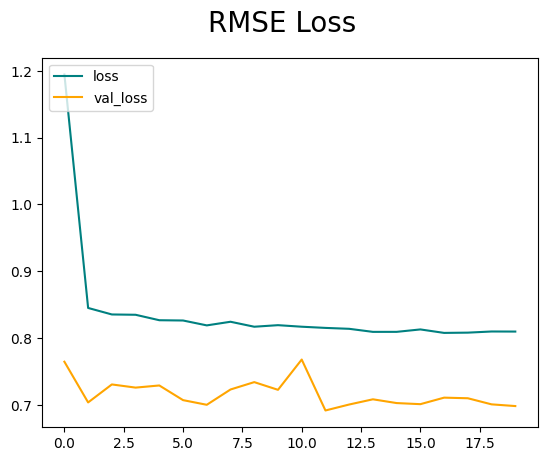

In [41]:
fig = plt.figure()
plt.plot(hist.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist.history['val_root_mean_squared_error'], color='orange', label='val_loss')
# plt.ylim(max_loss, min_loss)
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
model1 = load_model('models/model1/')

In [43]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results.head()

1875/1875 [==============================] - 2s 769us/step


,Train Predictions,Actuals
0,-9.680407,-9.67
1,-9.615618,-9.17
2,-8.705441,-8.10
3,-6.955798,-7.66
4,-6.634170,-7.04


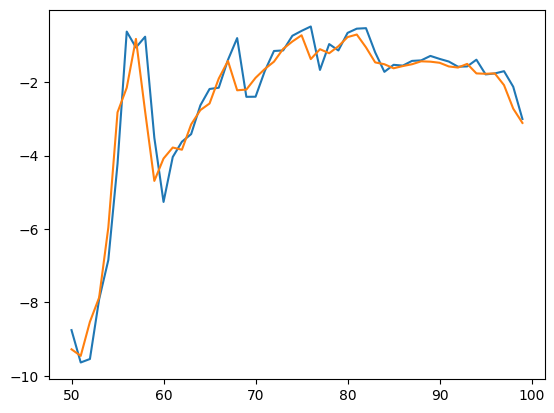

In [44]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [45]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results.head()

157/157 [==============================] - 0s 867us/step


,Val Predictions,Actuals
0,15.646160,14.02
1,13.390832,13.67
2,13.129172,12.27
3,11.542672,11.19
4,10.469726,10.85


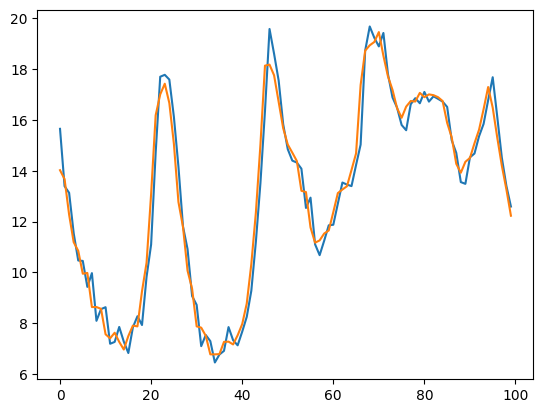

In [46]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [47]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results.head()

159/159 [==============================] - 0s 930us/step


,Test Predictions,Actuals
0,14.433522,13.99
1,13.294379,13.46
2,12.948710,12.93
3,12.492018,12.43
4,12.055753,12.17


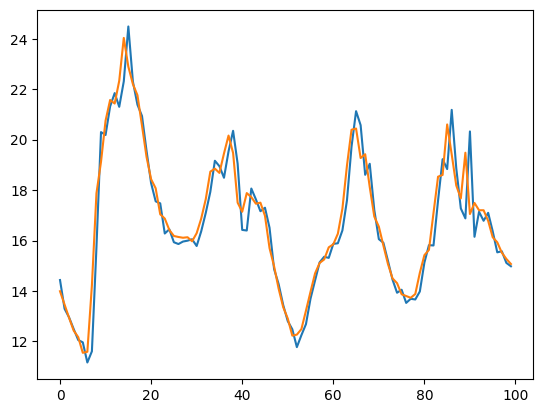

In [48]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])